# Cifar10 classification with and without normalization

In this notebook you will download the cifar10 dataset which contains quite small images (32x32x3) of 10 classes. The data is from the Canadian Institute For Advanced Research. You will plot examples of the images with the class label. Note that because the images are so small it's not always very easy to recoginse which of the ten classes is on the iamge, even as a human. After loading the dataset you will train multiple models and compare the performances of the models on the testset.

**Dataset:**  You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

**Content:**
* load the original cifar10 data create a train val and test dataset
* visualize samples of cifar10 dataset
* train a random forest on the pixelvalues
* train a random forest on the vgg16 features of the images
* use transfer learning with the pretrained vgg16 network
* train a cnn from scratch
* train a cnn from scratch with dropout
* train a cnn from scratch with batchnorm
* train a cnn from scratch with data augmentation
* compare the performances of the models




#### Imports

In the next two cells, we load all the required libraries and functions. We download the Mnist data, normalize the pixelvalues to be between 0 and 1, and seperate it into a training and validation set.

In [0]:
# load required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
from sklearn.ensemble import RandomForestClassifier



### Load and plot the data

In the next cell you will load the Cifar10 dataset, 50'000 images are in the training set and 10'000 are in the test dataset. You will use 10'000 for the train and validation dataset.
You will plot one random example of each label and will see
that the images are really small and finally you can convert the lables into the one hot encoding.


In [0]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
# separate train val and test dataset
X_train=x_train[0:10000] 
Y_train=to_categorical(y_train[0:10000],10) # one-hot encoding

X_val=x_train[20000:30000] 
Y_val=to_categorical(y_train[20000:30000],10)

X_test=x_test 
Y_test=to_categorical(y_test,10)

del x_train, y_train, x_test, y_test


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


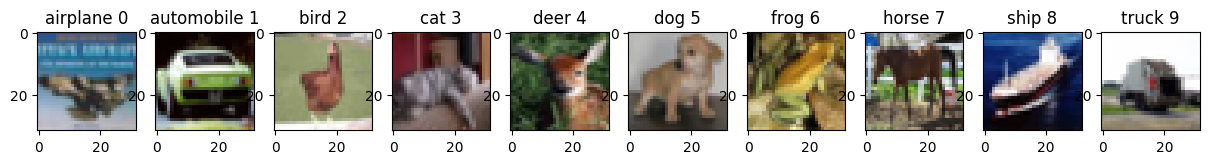

In [0]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(np.argmax(Y_train,axis=1)))):
    rmd=np.random.choice(np.where(np.argmax(Y_train,axis=1)==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+np.str(np.argmax(Y_train,axis=1)[rmd][0]))

In [0]:
# check the shape of the data
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((10000, 32, 32, 3), (10000, 10), (10000, 32, 32, 3), (10000, 10))

In [0]:
# normalization
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

### RF on pixelvalues
In this section you will train a random forest on the raw pixelvalues of the images.


In [0]:
clf = RandomForestClassifier(n_estimators=40,random_state=22)
clf.fit(X_train.reshape(len(X_train),32*32*3), np.argmax(Y_train,axis=1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [0]:
pred=clf.predict(X_test.reshape(len(X_test),32*32*3))
acc=np.average(pred==np.argmax(Y_test,axis=1))
res1 = pd.DataFrame(
          {'Acc' : acc}, index=['rf on pixelvalues'])
res1

,Acc
rf on pixelvalues,0.3932


### CNN from scratch
In this section you train a cnn from scratch to learn to classify the images into the right label.

In [0]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)             

In [0]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val, Y_val),verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 200us/sample - loss: 1.9136 - accuracy: 0.2801 - val_loss: 1.6918 - val_accuracy: 0.3959
Epoch 2/10
10000/10000 [==============================] - 1s 146us/sample - loss: 1.5079 - accuracy: 0.4391 - val_loss: 1.4217 - val_accuracy: 0.4736
Epoch 3/10
10000/10000 [==============================] - 1s 138us/sample - loss: 1.3055 - accuracy: 0.5256 - val_loss: 1.2769 - val_accuracy: 0.5330
Epoch 4/10
10000/10000 [==============================] - 1s 142us/sample - loss: 1.1124 - accuracy: 0.5988 - val_loss: 1.2203 - val_accuracy: 0.5621
Epoch 5/10
10000/10000 [==============================] - 1s 148us/sample - loss: 0.9576 - accuracy: 0.6526 - val_loss: 1.2273 - val_accuracy: 0.5692
Epoch 6/10
10000/10000 [==============================] - 1s 140us/sample - loss: 0.8150 - accuracy: 0.7104 - val_loss: 1.1870 - val_accuracy: 0.5941
Epoch 7/10
10000/10000 [==========================

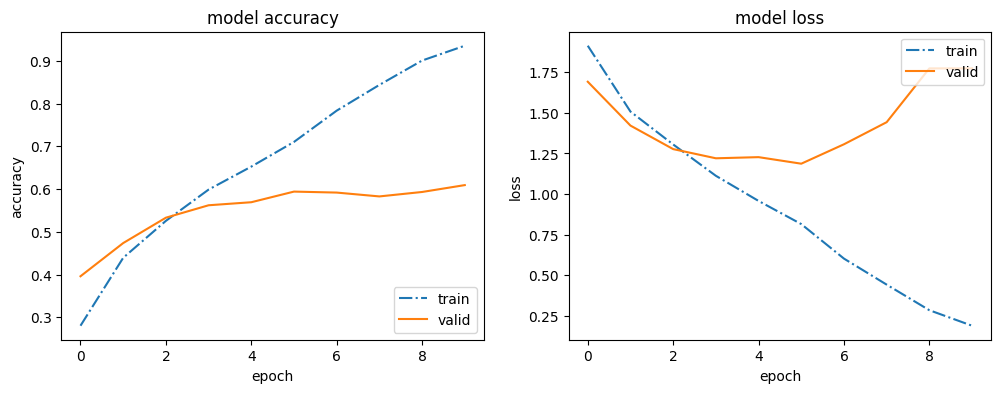

In [0]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [0]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res2 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch']
)
pd.concat([res1,res2])

,Acc
rf on pixelvalues,0.3932
cnn from scratch,0.6038


### CNN from scratch with Dropout
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use dropout layers in the classification part.

In [0]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)             

In [0]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=20, validation_data=(X_val, Y_val),verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 2s 205us/sample - loss: 2.0158 - accuracy: 0.2449 - val_loss: 1.6943 - val_accuracy: 0.3616
Epoch 2/20
10000/10000 [==============================] - 1s 143us/sample - loss: 1.6181 - accuracy: 0.3942 - val_loss: 1.4193 - val_accuracy: 0.4734
Epoch 3/20
10000/10000 [==============================] - 1s 142us/sample - loss: 1.4234 - accuracy: 0.4744 - val_loss: 1.3297 - val_accuracy: 0.5143
Epoch 4/20
10000/10000 [==============================] - 1s 144us/sample - loss: 1.2981 - accuracy: 0.5298 - val_loss: 1.2947 - val_accuracy: 0.5283
Epoch 5/20
10000/10000 [==============================] - 1s 139us/sample - loss: 1.1793 - accuracy: 0.5742 - val_loss: 1.1570 - val_accuracy: 0.5860
Epoch 6/20
10000/10000 [==============================] - 1s 137us/sample - loss: 1.0673 - accuracy: 0.6185 - val_loss: 1.1202 - val_accuracy: 0.6007
Epoch 7/20
10000/10000 [==========================

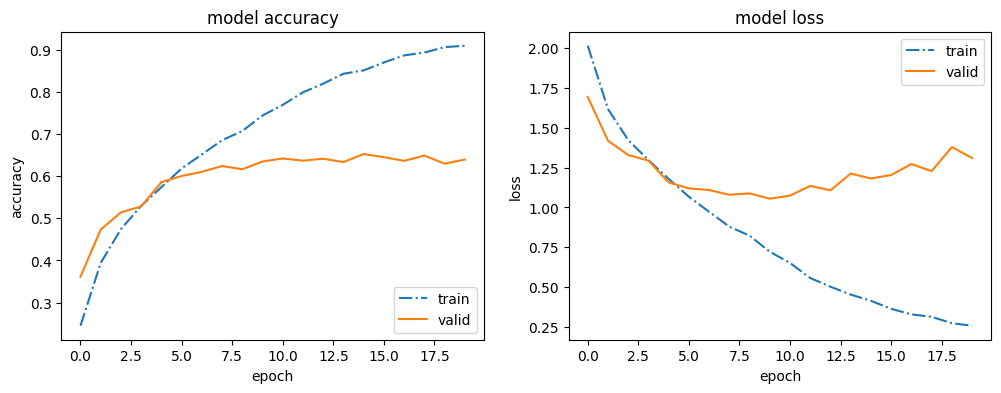

In [0]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [0]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res3 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with dropout']
)
pd.concat([res1,res2,res3])

,Acc
rf on pixelvalues,0.3932
cnn from scratch,0.6038
cnn from scratch with dropout,0.6315


### CNN from scratch with Batchnorm
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use batchnorm on the input and in the convolutional part of the network. Note that we reload the original images and do not normalize them.

In [0]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# separate train val and test dataset
X_train_=x_train[0:10000] 
Y_train=to_categorical(y_train[0:10000],10) # one-hot encoding

X_val_=x_train[20000:30000] 
Y_val=to_categorical(y_train[20000:30000],10)

X_test_=x_test 
Y_test=to_categorical(y_test,10)

del x_train, y_train, x_test, y_test


print(X_train_.shape)
print(X_val_.shape)
print(X_test_.shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
# not normalized, values between 0 and 255
X_train_[0,0:10,0,0]

array([ 59,  16,  25,  33,  50,  71,  97, 115, 137, 154], dtype=uint8)

In [0]:
model  =  Sequential()

model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 16)       

In [0]:
history = model.fit(X_train_, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val_, Y_val),verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 3s 265us/sample - loss: 1.7163 - accuracy: 0.3659 - val_loss: 2.0495 - val_accuracy: 0.2581
Epoch 2/10
10000/10000 [==============================] - 1s 142us/sample - loss: 1.3680 - accuracy: 0.5007 - val_loss: 1.3160 - val_accuracy: 0.5230
Epoch 3/10
10000/10000 [==============================] - 1s 142us/sample - loss: 1.1826 - accuracy: 0.5699 - val_loss: 1.3014 - val_accuracy: 0.5366
Epoch 4/10
10000/10000 [==============================] - 1s 142us/sample - loss: 1.0152 - accuracy: 0.6365 - val_loss: 1.2154 - val_accuracy: 0.5757
Epoch 5/10
10000/10000 [==============================] - 1s 143us/sample - loss: 0.8780 - accuracy: 0.6898 - val_loss: 1.1320 - val_accuracy: 0.6022
Epoch 6/10
10000/10000 [==============================] - 1s 145us/sample - loss: 0.7716 - accuracy: 0.7187 - val_loss: 1.0571 - val_accuracy: 0.6390
Epoch 7/10
10000/10000 [==========================

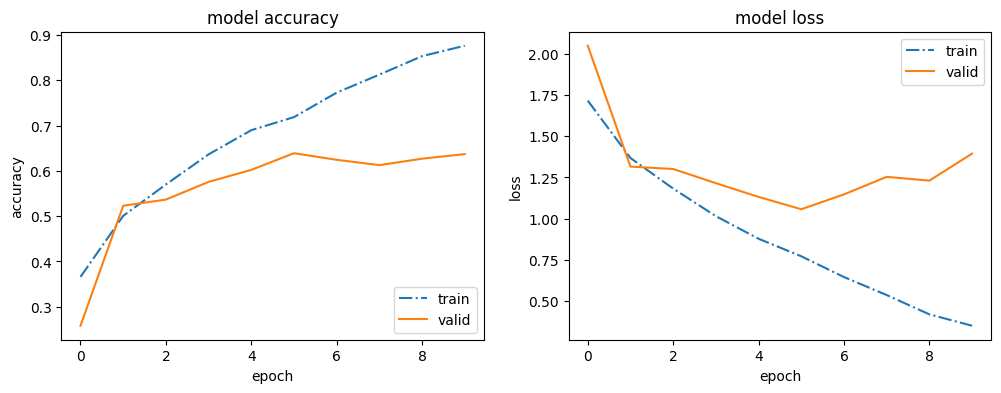

In [0]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [0]:
acc=np.average(np.argmax(model.predict(X_test_),axis=1)==np.argmax(Y_test,axis=1))
res4 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with batchnorm']
)
pd.concat([res1,res2,res3,res4])

,Acc
rf on pixelvalues,0.3932
cnn from scratch,0.6038
cnn from scratch with dropout,0.6315
cnn from scratch with batchnorm,0.6332


#### Exercise
Calculate the confusion matrix of the networks.  
Play around with the dropout rate and the position of the batchnorm.

# Learning with few data
In case of few data you can work with features that you extract from a pretrained cnn. Data augmentation inceases the training data and usually help to improve the performace. 

### Baseline model: RF on VGG features
In this section you use a pretrained vgg16 network that was trained on the imagenet data as a image feature extractor and then train a random forest on these features. You will extract a 512 dimensional vector from each image.


In [0]:
# load the pretrained vgg model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=(32,32,3),pooling="avg")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [0]:
# extract the vgg features of the images
X_train_vgg_features=base_model.predict(X_train)
X_val_vgg_features=base_model.predict(X_val)
X_test_vgg_features=base_model.predict(X_test)


In [0]:
# train a random forest on the vgg features
clf = RandomForestClassifier(n_estimators=40,random_state=22)
clf.fit(X_train_vgg_features, np.argmax(Y_train,axis=1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [0]:
# use the trained vgg features to predict the test features
pred=clf.predict(X_test_vgg_features)
acc=np.average(pred==np.argmax(Y_test,axis=1))
res5 = pd.DataFrame(
          {'Acc' : acc}, index=['rf on vgg features']
)
pd.concat([res1,res2,res3,res4,res5])

,Acc
rf on pixelvalues,0.3932
cnn from scratch,0.6038
cnn from scratch with dropout,0.6315
cnn from scratch with batchnorm,0.6332
rf on vgg features,0.4629


### Transfer learning
In this section you use a pretrained vgg16 network that was trained on the imagenet and keep the weights of the convolutional part fixed. You will add your own classification part (fully connected layers) on top of the imagetnet-learned convolutional part. Only the classification part will be learned, we fix all other weights.

In [0]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=(32,32,3))
x = base_model.output
x = Flatten()(x)
x = Dense(400, activation='relu')(x)
x = Dense(200, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)



In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [0]:
# freeze the weights of the convolutional part
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
for i, layer in enumerate(model.layers):
   print(i, layer.name,layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_8 True
20 dense_31 True
21 dense_32 True
22 dense_33 True


In [0]:
history=model.fit(X_train, Y_train, 
                  batch_size=64, 
                  epochs=15,
                  verbose=1,
                  shuffle=True,
                  validation_data=(X_val, Y_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/15
10000/10000 [==============================] - 4s 376us/sample - loss: 1.5818 - accuracy: 0.4433 - val_loss: 1.4203 - val_accuracy: 0.5139
Epoch 2/15
10000/10000 [==============================] - 3s 308us/sample - loss: 1.2864 - accuracy: 0.5496 - val_loss: 1.2890 - val_accuracy: 0.5499
Epoch 3/15
10000/10000 [==============================] - 3s 311us/sample - loss: 1.1737 - accuracy: 0.5884 - val_loss: 1.2553 - val_accuracy: 0.5579
Epoch 4/15
10000/10000 [==============================] - 3s 307us/sample - loss: 1.0930 - accuracy: 0.6227 - val_loss: 1.2963 - val_accuracy: 0.5419
Epoch 5/15
10000/10000 [==============================] - 3s 315us/sample - loss: 1.0299 - accuracy: 0.6377 - val_loss: 1.2357 - val_accuracy: 0.5694
Epoch 6/15
10000/10000 [==============================] - 3s 308us/sample - loss: 0.9561 - accuracy: 0.6605 - val_loss: 1.2455 - val_accuracy: 0.5713
Epoch 7/15
10000/10000 [==========================

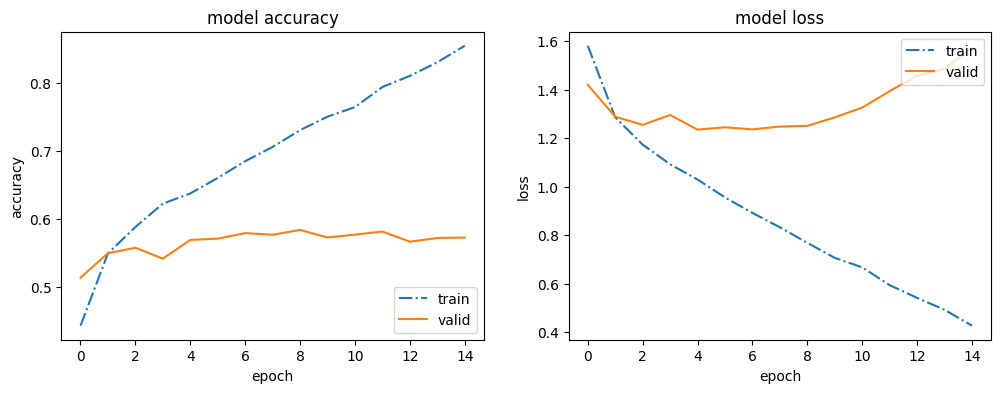

In [0]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [0]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res6 = pd.DataFrame(
          {'Acc' : acc}, index=['transfer learning on vgg features']
)
pd.concat([res1,res2,res3,res4,res5,res6])

,Acc
rf on pixelvalues,0.3932
cnn from scratch,0.6038
cnn from scratch with dropout,0.6315
cnn from scratch with batchnorm,0.6332
rf on vgg features,0.4629
transfer learning on vgg features,0.5643


### CNN from scratch with Data Augmentation
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use data augmentation, so the network will train on slightly different versions of the images in each epoch.

In [0]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)             

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
fill_mode="constant",
cval=1,horizontal_flip=True)

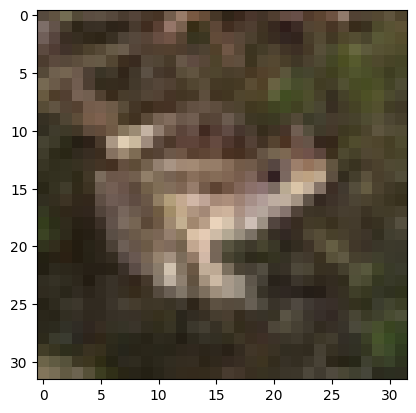

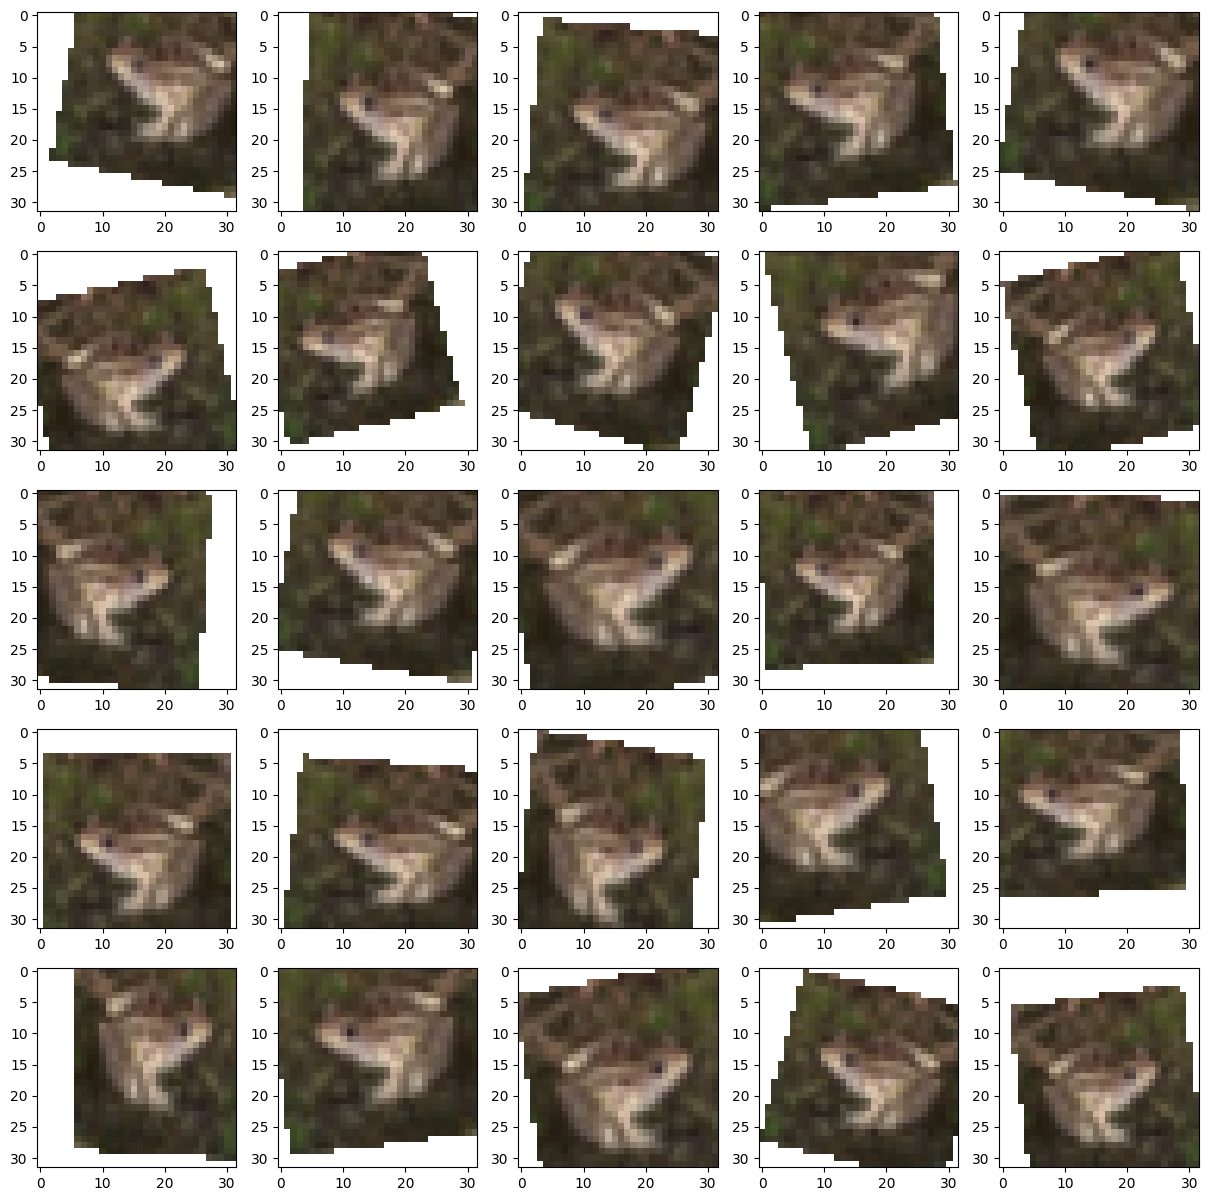

In [0]:
i=22
data_aug=datagen.flow(x=X_train[i:(i+1)], y=Y_train[i:(i+1)], batch_size=1)
plt.imshow(X_train[i])
plt.show()
plt.figure(figsize=(15,15))
for i in range (0,25):
  plt.subplot(5,5,i+1)
  x_aug,y_aug=next(data_aug)
  plt.imshow(x_aug[0,:,:,:])

In [0]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64), 
                              steps_per_epoch=len(X_train)/64, 
                              epochs=40, 
                              validation_data=(X_val, Y_val),
                              verbose=1)

  ...
    to  
  ['...']
Train for 156.25 steps, validate on 10000 samples
Epoch 1/40
157/156 [==============================] - 6s 37ms/step - loss: 2.0943 - accuracy: 0.2094 - val_loss: 1.8723 - val_accuracy: 0.2883
Epoch 2/40
157/156 [==============================] - 5s 34ms/step - loss: 1.8380 - accuracy: 0.3118 - val_loss: 1.7275 - val_accuracy: 0.3507
Epoch 3/40
157/156 [==============================] - 5s 34ms/step - loss: 1.7023 - accuracy: 0.3563 - val_loss: 1.6725 - val_accuracy: 0.3868
Epoch 4/40
157/156 [==============================] - 5s 34ms/step - loss: 1.5820 - accuracy: 0.4134 - val_loss: 1.5792 - val_accuracy: 0.4261
Epoch 5/40
157/156 [==============================] - 5s 34ms/step - loss: 1.5231 - accuracy: 0.4368 - val_loss: 1.4210 - val_accuracy: 0.4770
Epoch 6/40
157/156 [==============================] - 5s 34ms/step - loss: 1.4703 - accuracy: 0.4547 - val_loss: 1.3738 - val_accuracy: 0.4948
Epoch 7/40
157/156 [==============================] - 5s 34ms/step 

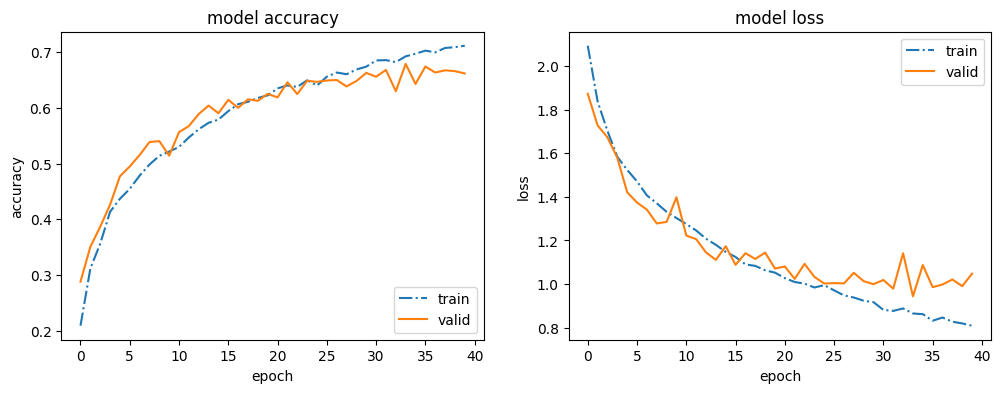

In [0]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [0]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
acc
res7 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with data augmentation']
)
pd.concat([res1,res2,res3,res4,res5,res6,res7])

,Acc
rf on pixelvalues,0.3932
cnn from scratch,0.6038
cnn from scratch with dropout,0.6315
cnn from scratch with batchnorm,0.6332
rf on vgg features,0.4629
transfer learning on vgg features,0.5643
cnn from scratch with data augmentation,0.6525


#### Exercise
Try to beat the performace of the best network with your own neutal network.  
*Hint: You might want to combine things from the neural networks above*